<a href="https://colab.research.google.com/github/yixin0829/multi_label_wine_quality_classification/blob/master/Wine_Quality_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Wine Quality Classification


---







In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Context & Workflow in Mind
The dataset is pulled through Kaggle API. The dataset is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009].

### **Tools & Models**


**The plan** is to use the dataset to train some multi-label classification models using different ML models and compare their performance + analyze why they differentiate: 


*   Logistic regression
*   K-NN
*   SVM



### **Workflow**



*   Import libraries & data
*   Exploratory analysis & Data visualization
*   Data preprocessing
*   Rapid prototyping (train a logistic regression classifer with one vs. all method)
*   Feature engineering
*   Interating for better performance (precision/recall & F score)

## Import Libararies

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


### Use the right version of TensorFlow
The following hidden code cell ensures that the Colab will run on TensorFlow 2X.

In [ ]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x

## Downloading dataset (Kaggle API)

Not sure comparing with downloading dataset from Kaggle which method is better. My understanding is using API might just demostrate a bit more knowledge of API and also can indicate the data source. The down side could be I'm exposing my user name and token?

In [ ]:
#@title Setting up Kaggle API
#!pip install kaggle
!rm -r .kaggle
!mkdir .kaggle

import json
token = {"username":"MY USER NAME","key":"<KEY>"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

rm: cannot remove '.kaggle': No such file or directory
cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Downloading dataset from Kaggle
#@title Viewing datasets from Kaggle
!kaggle datasets list -s Red

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
# Copy the API key from Kaggle and set the path -p
!kaggle datasets download -d uciml/red-wine-quality-cortez-et-al-2009 -p /content/

# Unzip the datasets just downloaded
!unzip \*.zip
# Remove the extra .zip file
!rm /content/*.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.
rm: cannot remove '/content/*.zip': No such file or directory


## Importing Dataset

In [3]:
wine_df = pd.read_csv("./drive/My Drive/Multi-label Wine Quality Classification/winequality-red.csv")
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
wine_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [ ]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## Exploratory Analysis & Data Visualizations

### Skewed Classes

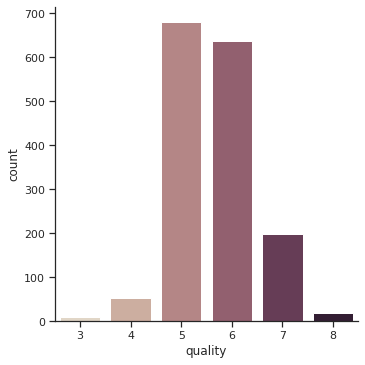

In [ ]:
# Visualize the categorical labels first
sns.set(style="ticks", color_codes=True)

sns.catplot(x="quality", kind="count", palette="ch:.25", data=wine_df);

In [ ]:
wine_df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Note that the classes are pretty unenvenly distributed. There are much more normal wines than excellent or poor ones (Need to research more on how to deal with situation). In general seems we got 6 categaories in here from grading 3 - 8.

### Correlation Analysis

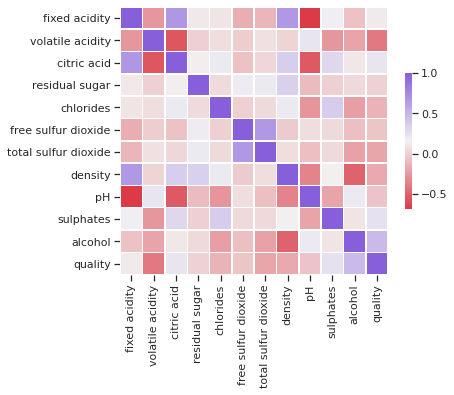

In [ ]:
corr = wine_df.corr(method = 'pearson')
f, ax = plt.subplots(figsize=(6, 5))
cmap = sns.diverging_palette(10, 275, as_cmap=True)

sns.heatmap(corr, cmap=cmap, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.5}, ax=ax)

Seems PH and fixed acidity, citric acid and PH/volatile acidity have high negtive correlation. Later we can consider to combine these features by apply principal component analysis (PCA). However, for now let's get something quick and dirty working first. However it may be helpful to plot the xy scattet plots for better visualization of the correlations between different features.

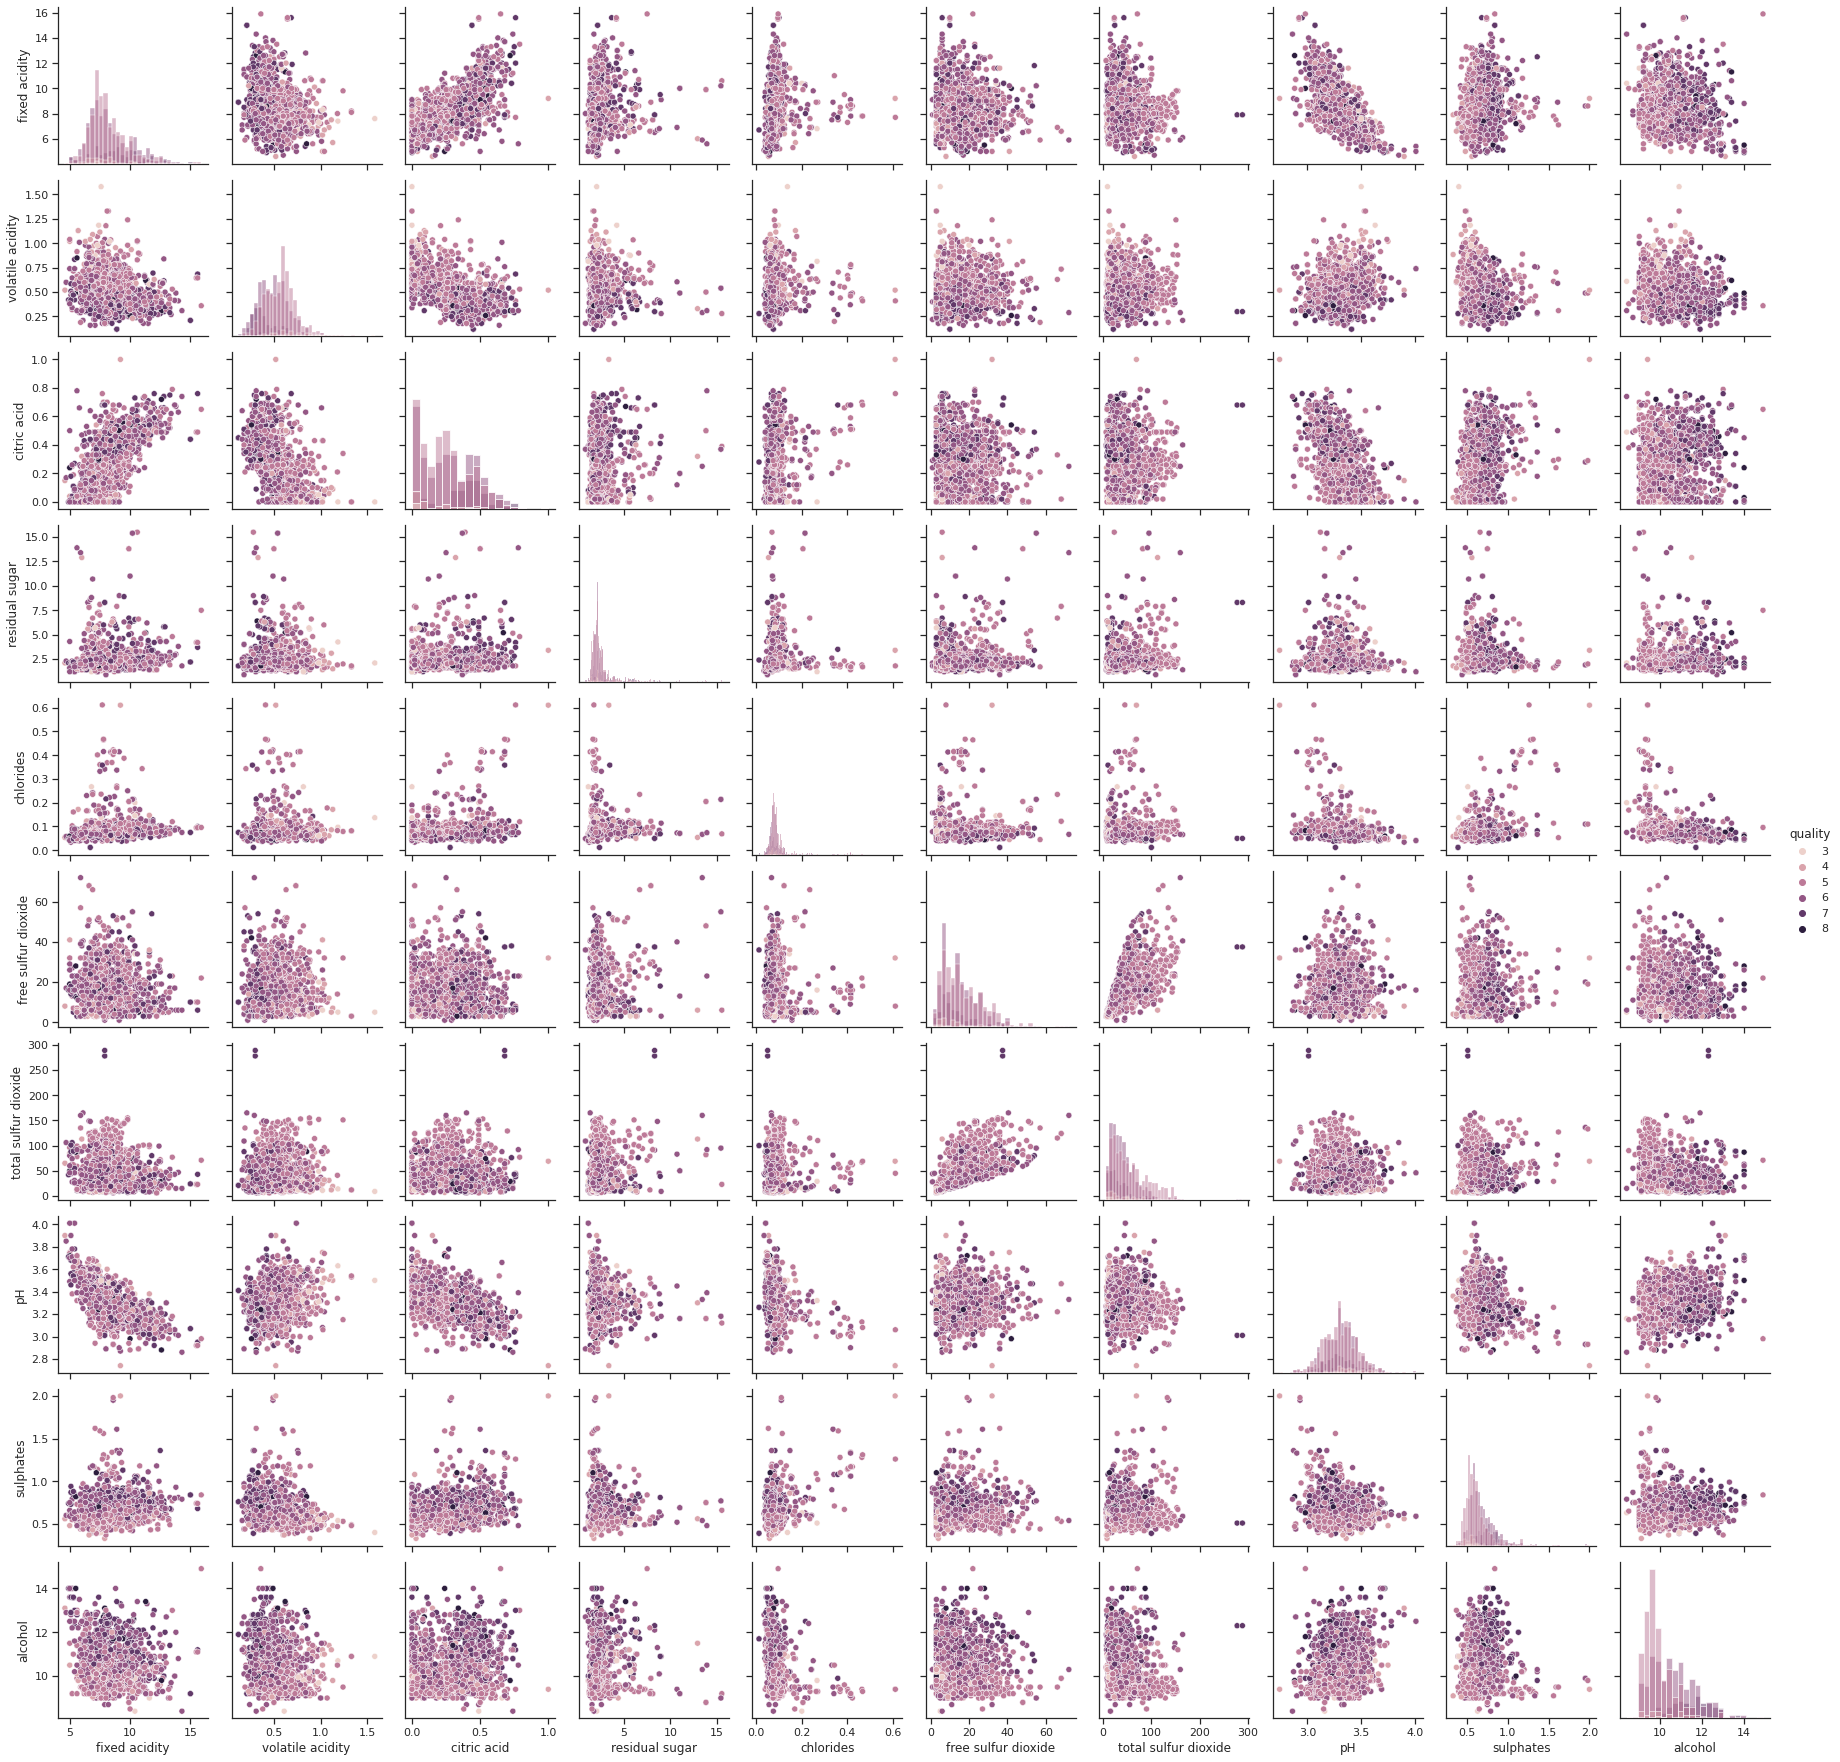

In [ ]:
g = sns.PairGrid(wine_df, hue="quality")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

### Plotting Features w.r.t. Labels (Wine Quality)

A bar plot represents an estimate of central tendency for a numeric variable with the height of each rectangle and provides some indication of the uncertainty around that estimate using error bars.

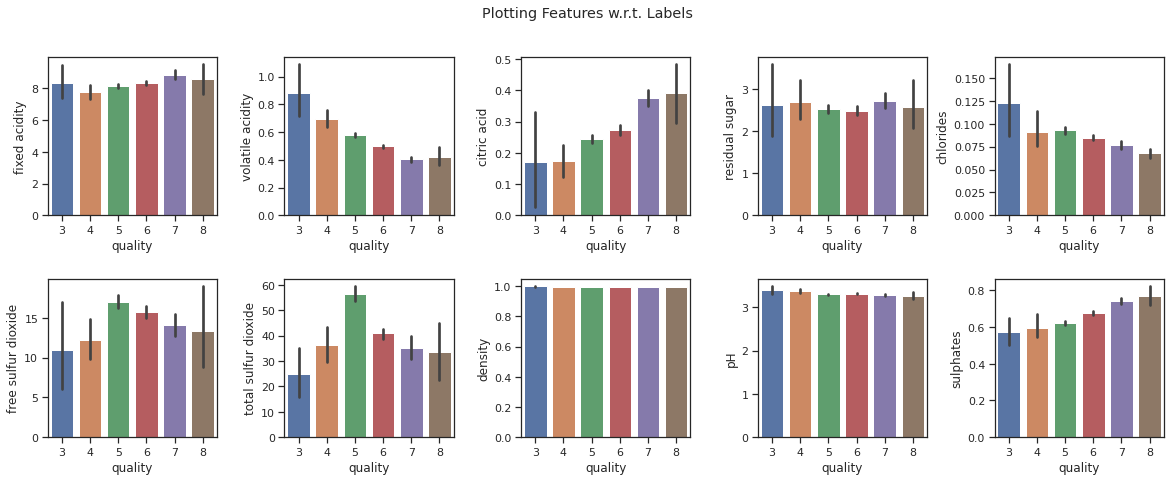

In [ ]:
# Creating a 2 x 5 subplot grid
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,7))
figure.suptitle("Plotting Features w.r.t. Labels")
# wspace: the amount of width reserved for space between subplots, expressed as a fraction of the average axis width
# hspace; the amount of height reserved for space between subplots, expressed as a fraction of the average axis height
figure.subplots_adjust(hspace=0.4, wspace= 0.4)

# Using for loop to interate through different features and plot its barplot against wine "quality" feature (categorical data)
for i in range(2):
  for j in range(5):
    sns.barplot(ax=axes[i,j], x='quality', y=wine_df.columns[i*5 + j], data = wine_df)


From the barplots above we see features like "fixed acidity", "residual sugar", "density", "PH" have almost no effect on predicting the quality of wine. We'll take out feature "density" in here since it does not have any correlation wrt wine quality.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


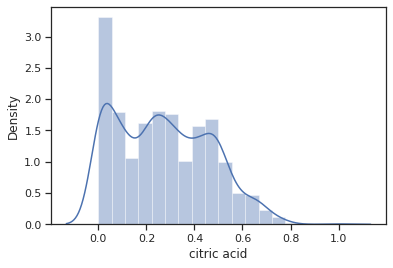

In [ ]:
# Visualize the distribution of citric acid since previously apply .describe() on wine_df citric acid has a minimum of 0
citric_acid = pd.Series(wine_df.loc[:,'citric acid'])
sns.distplot(citric_acid)

Not sure if citric acid = 0 is valid or not.

## Data Preprocessing

### Drop "density" data column

We'll drop "density" column as we discussed in the exploratory analysis section and keep the rest data the same. For more in depth preprocessing (e.g. PCA), we'll come back to it later after we trained our first quick, dirty classifier using logistic regression.

In [5]:
wine_df = wine_df.drop(labels='density', axis=1)
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,3.51,0.56,9.4,5


### Encoding the 'quality' col


In [6]:
# instead of using sklearn.preprocessing -> OneHotEncoder class (which require to convert pandas dataframe to numpy array)
# We use pandas' get_dummies method, notice the prefix param makes the resulted one hot key encoded matrix more readable
one_hot_label = pd.get_dummies(wine_df.quality, prefix='quality')
one_hot_label.head()

,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


Initial thought was one hot encode wine quality and train 6 binary classification models to apply one vs. all. However, sklearn has the parameter in their classification fit methods that allows categorical multi-label classes (i.e. y) 

In [28]:
X = wine_df.iloc[:, :-1]
y_one_hot = one_hot_label
y = wine_df.iloc[:, -1]
print("the dimension of X training examples is:" + str(X.shape) + "\n the dimension of y training examples is:" + str(y.shape))

the dimension of X training examples is:(1599, 10)
 the dimension of y training examples is:(1599,)


### Splitting into Training/Test Sets

Different from binary classification problem, in here we'll have 6 y_train & y_test label sets each corresponding one column in the y matrix. The first step is to split the numpy arrays into trianing & test sets.

In [78]:
from sklearn.model_selection import train_test_split
# Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)
print(X_train.shape)
print(type(X_train))

(1071, 10)
<class 'pandas.core.frame.DataFrame'>


### Oversampling Minority Classes (2nd Iteration - in progress)

Note we only oversampling the minority classes on our training set, not test set.

In [79]:
# Our goal to is oversample wine quality 3,4,6,7,8 to have the same samples as the most common wine quality (label) 5 i.e. 456 samples
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the wine quality array:")

y_train.value_counts()

Frequency of unique values of the wine quality array:


5    456
6    428
7    134
4     32
8     13
3      8
Name: quality, dtype: int64

In [81]:
from sklearn.utils import resample

#combine them back for resampling
train_data = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
quality_3 = train_data[train_data.quality==3]
quality_4 = train_data[train_data.quality==4]
quality_5 = train_data[train_data.quality==5]
quality_6 = train_data[train_data.quality==6]
quality_7 = train_data[train_data.quality==7]
quality_8 = train_data[train_data.quality==8]

# upsample minority
quality_3_upsampled = resample(quality_3, replace=True, # sample with replacement
                    n_samples=len(quality_7), # match number in majority class 456 samples in this case
                    random_state=None) # reproducible results

quality_4_upsampled = resample(quality_4, replace=True, # sample with replacement
                    n_samples=len(quality_7), # match number in majority class 456 samples in this case
                    random_state=None) # reproducible results

quality_6_upsampled = resample(quality_6, replace=True, # sample with replacement
                    n_samples=len(quality_7), # match number in majority class 456 samples in this case
                    random_state=None) # reproducible results   
                                     
quality_7_upsampled = resample(quality_7, replace=True, # sample with replacement
                    n_samples=len(quality_7), # match number in majority class 456 samples in this case
                    random_state=None) # reproducible results

quality_8_upsampled = resample(quality_8, replace=True, # sample with replacement
                    n_samples=len(quality_7), # match number in majority class 456 samples in this case
                    random_state=None) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([quality_5, quality_3_upsampled, quality_4_upsampled, quality_6_upsampled, quality_7_upsampled, quality_8_upsampled], axis=0) #axis=0 append vertically (i.e. row)


print("Frequency of unique values of the wine quality array after oversampling:")
upsampled.quality.value_counts()

Frequency of unique values of the wine quality array after oversampling:


5    456
8    134
7    134
6    134
4    134
3    134
Name: quality, dtype: int64

In [89]:
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

### Feature Scaling

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_tranform call .fit() to compute the mean and std deviation for later use 
# Note: the return type of .fit_transform is ndarray
X_train = scaler.fit_transform(X_train)
# No need to call fit_transform again since the params have been computed in the previous line
X_test = scaler.transform(X_test)

In [72]:
print(X_train.shape)
print(type(X_train))

(2736, 10)
<class 'numpy.ndarray'>


## Trian Models

### Train a multi-class logistic regression classifier (one vs. all)




In [91]:
from sklearn.linear_model import LogisticRegression

# No params are passing in here into the LogisticRegression class (i.e. no tuning)
logReg_clf = LogisticRegression(random_state = 0, multi_class='ovr', max_iter=10000).fit(X_train, y_train)

### SVM

In [92]:
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(random_state = 0, multi_class='ovr', max_iter=10000).fit(X_train, y_train)

### K-NN

In [93]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=6)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

## Predicting the Test Set Results

1st Iteration:

In [ ]:
# Predit the test data Note: the output y_pred is a numpy array
y_pred_log = logReg_clf.predict(X_test)
y_pred_svm = svm_clf.predict(X_test)
y_pred_knn = knn_clf.predict(X_test)

from sklearn.metrics import classification_report
#Let's see how our model performed
print("-------------- Logistic Regression --------------")
print(classification_report(y_test, y_pred_log))
print("-------------- SVM --------------")
print(classification_report(y_test, y_pred_svm))
print("-------------- K-NN --------------")
print(classification_report(y_test, y_pred_knn))

-------------- Logistic Regression --------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        21
           5       0.64      0.79      0.71       225
           6       0.55      0.59      0.57       210
           7       0.48      0.17      0.25        65
           8       0.00      0.00      0.00         5

    accuracy                           0.59       528
   macro avg       0.28      0.26      0.25       528
weighted avg       0.55      0.59      0.56       528

-------------- SVM --------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        21
           5       0.64      0.81      0.71       225
           6       0.53      0.59      0.56       210
           7       0.33      0.05      0.08        65
           8       0.00      0.00      0.00     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The f1-score gives us the harmonic mean of precision and recall. The scores corresponding to every class will tell us the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.

The support is the number of samples we have for each class.

Since we have severly skewed classes. Accuracy may not be a good choice of metric of measuring the model performance. We'll use F1-score as our metric.

---



2nd Iteration:

In [94]:
# Predit the test data Note: the output y_pred is a numpy array
y_pred_log = logReg_clf.predict(X_test)
y_pred_svm = svm_clf.predict(X_test)
y_pred_knn = knn_clf.predict(X_test)

from sklearn.metrics import classification_report
#Let's see how our model performed
print("-------------- Logistic Regression --------------")
print(classification_report(y_test, y_pred_log))
print("-------------- SVM --------------")
print(classification_report(y_test, y_pred_svm))
print("-------------- K-NN --------------")
print(classification_report(y_test, y_pred_knn))

-------------- Logistic Regression --------------
              precision    recall  f1-score   support

           3       0.05      0.50      0.08         2
           4       0.23      0.14      0.18        21
           5       0.56      0.91      0.69       225
           6       0.82      0.04      0.08       210
           7       0.28      0.25      0.26        65
           8       0.05      0.60      0.09         5

    accuracy                           0.45       528
   macro avg       0.33      0.41      0.23       528
weighted avg       0.61      0.45      0.37       528

-------------- SVM --------------
              precision    recall  f1-score   support

           3       0.04      0.50      0.07         2
           4       0.00      0.00      0.00        21
           5       0.55      0.89      0.68       225
           6       1.00      0.02      0.05       210
           7       0.30      0.25      0.27        65
           8       0.05      0.60      0.09     

Comparing with the 1st iteration, we can see the performance (f1-score) has increased in minority classes. Some problems may worth attention in here:
1. what's the optimal oversampling size?
2. quality_6 has much lower f1_score comparing with the 1st iteration. Why?



### Making the confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred_log)
print(confusion)

Confusion matrix of a multi-label classifier can be complex to interpret.

**2nd Iteration:** try **oversampling** minority training example.
More details can be found in [HERE](https://towardsdatascience.com/what-to-do-when-your-classification-dataset-is-imbalanced-6af031b12a36).